# **Modelling and evaluation**


### Objectives

- **Answering business requirement 2:**
    * The client wants us to develop a machine learning model that can predict with an accuracy higher than 80%.

### Inputs

- inputs/dataset/raw/flower_photos/train<br>
- inputs/dataset/raw/flower_photos/validation<br>
- inputs/dataset/raw/flower_photos/test<br>

### Outputs

- Image augmentation<br>
- Machine learning model creation and training the model<br>
- Plot showing learning curve for model performance<br>
- Model evaluation as a JSON-file<br>
- Confusion matrix as a heatmap


## **Install Requirements and Prepare Workspace**

### Workspace setup

First let see that we are working from the correct directory that should be "flowers_CNN".<br>
By default the working directory is "..../flowers_CNN/jupyter_notebook"

In [1]:
import os
working_dir = os.getcwd()
print(f"You are now working in {working_dir}")
print("If you need to change to the parent directory, run the cell below")

You are now working in c:\Users\fredd\Desktop\Studier\Project5\Flower-bingo\flowers_CNN\jupyter_notebooks
If you need to change to the parent directory, run the cell below


In [2]:
os.chdir(os.path.dirname(working_dir))
new_working_dir = os.getcwd()
print(f"You have now changed your working directory to {new_working_dir}")

You have now changed your working directory to c:\Users\fredd\Desktop\Studier\Project5\Flower-bingo\flowers_CNN


### Set output destination

In [3]:
version = 'v8'
file_path = f'outputs/{version}'
current_working_dir = os.getcwd()

if 'outputs' in os.listdir(current_working_dir) and version in os.listdir(current_working_dir + '/outputs'):
    print("This version already exists, create a new version if you are working on a new version")
    pass
else:
    os.makedirs(name=file_path)

This version already exists, create a new version if you are working on a new version


### Set folder paths

In [10]:
image_dirs = 'inputs/dataset/raw/flower_photos'
train_path = image_dirs + '/train'
val_path = image_dirs + '/validation'
test_path = image_dirs + '/test'

### Import packages

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import json
import random

## Create model

In [11]:
class ImageClassificationPipeline:
    """
    A class to handle the complete pipeline for training, evaluating, and visualizing an image classification model.
    
    This class provides methods to:
    1. Initialize data generators for training, validation, and test sets from directory-based image data.
    2. Build a Convolutional Neural Network (CNN) model for classification tasks.
    3. Train the model with data augmentation and early stopping to avoid overfitting.
    4. Evaluate the model using classification metrics such as F1-score, classification report, and confusion matrix.
    5. Visualize training history with accuracy and loss curves.
    6. Save the model and evaluation results to specified paths.

    Attributes:
    - train_path: str, the path to the training data directory.
    - val_path: str, the path to the validation data directory.
    - test_path: str, the path to the test data directory.
    - input_shape: tuple, the shape of input images (default is (224, 224, 3)).
    - batch_size: int, the batch size for training (default is 20).
    - num_classes: int, the number of output classes (default is 5).
    - train_set: DirectoryIterator, generator for the training data.
    - validation_set: DirectoryIterator, generator for the validation data.
    - test_set: DirectoryIterator, generator for the test data.
    - model: keras Model, the CNN model used for classification.
    - history: History, the training history object that stores training/validation metrics.

    Methods:
    - __init__: Initializes the pipeline with directories, image shape, batch size, and number of classes.
    - build_model: Builds a CNN model using Conv2D, MaxPooling2D, Dense, Dropout layers, and softmax output layer.
    - train: Trains the model with data augmentation and early stopping.
    - evaluate: Evaluates the model on the test set and prints metrics like F1-score, classification report, and confusion matrix.
    - plot_training_history: Plots and saves the training/validation accuracy and loss over epochs.
    - save_model: Saves the trained model to a specified file path.
    - model_summary: Displays a summary of the model architecture.
    """
    def __init__(self, train_path, val_path, test_path, input_shape=(224, 224, 3), batch_size=20, num_classes=5):
        """
        Initialize the ImageClassificationPipeline object with paths for training, validation, 
        and test datasets, as well as other parameters for model setup.
        
        Parameters:
        - train_path: str, path to the training dataset.
        - val_path: str, path to the validation dataset.
        - test_path: str, path to the test dataset.
        - input_shape: tuple, shape of input images (default is (224, 224, 3)).
        - batch_size: int, batch size for data generators (default is 20).
        - num_classes: int, number of output classes (default is 5).
        """
        self.train_path = train_path
        self.val_path = val_path
        self.test_path = test_path
        self.input_shape = input_shape
        self.batch_size = batch_size
        self.num_classes = num_classes

        # Initialize ImageDataGenerators with data augmentation for training and rescaling for validation/test
        self.train_datagen = ImageDataGenerator(
            rescale=1./255, # Normalize pixel values
            rotation_range=20, # Random rotation within a range
            width_shift_range=0.10, # Random horizontal shift
            height_shift_range=0.10, # Random vertical shift
            shear_range=0.1, # Random shearing transformation
            zoom_range=0.1, # Random zoom
            horizontal_flip=True, # Random horizontal flip
            vertical_flip=True, # Random vertical flip
            fill_mode='nearest' # Fill missing pixels after transformations
        )
        self.val_test_datagen = ImageDataGenerator(rescale=1./255)

        # Build data generators using the specified dataset paths
        self.train_set = self.train_datagen.flow_from_directory(
            self.train_path, target_size=self.input_shape[:2], batch_size=self.batch_size,
            class_mode='categorical', shuffle=True
        )
        self.validation_set = self.val_test_datagen.flow_from_directory(
            self.val_path, target_size=self.input_shape[:2], batch_size=self.batch_size,
            class_mode='categorical', shuffle=False
        )
        self.test_set = self.val_test_datagen.flow_from_directory(
            self.test_path, target_size=self.input_shape[:2], batch_size=self.batch_size,
            class_mode='categorical', shuffle=False
        )
        # Print class labels to map indices
        print("Class indices:", self.train_set.class_indices)
        
        # Retrieve label map from the training set
        self.label_map = list(self.train_set.class_indices.keys())
        
        # Build the CNN model
        self.model = self.build_model()

    def build_model(self):
        """
        Constructs a CNN model for image classification.
        
        The model consists of three convolutional layers followed by fully connected layers, 
        and uses dropout for regularization.
        
        Returns:
        - model: A compiled Keras Sequential model ready for training.
        """
        model = Sequential([
            # First convolutional layer
            Conv2D(16, (3, 3), activation='relu', input_shape=self.input_shape),
            MaxPooling2D(pool_size=(2, 2)),
            
            # Second convolutional layer
            Conv2D(32, (3, 3), activation='relu'),
            MaxPooling2D(pool_size=(2, 2)),
            
            # Third convolutional layer
            Conv2D(64, (3, 3), activation='relu'),
            MaxPooling2D(pool_size=(2, 2)),            
            
            Flatten(), # Flatten the output of the convolutional layers
            Dense(64, activation='relu'), # Fully connected layer
            Dropout(0.5), # Dropout layer for regularization
            Dense(self.num_classes, activation='softmax') # Output layer with softmax activation
        ])
        
        # Compile the model using Adam optimizer and categorical crossentropy loss function
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        return model

    def train(self, epochs=25, early_stopping_patience=3):
        """
        Train the model on the training dataset with early stopping based on validation loss.
        
        Parameters:
        - epochs: int, the number of epochs to train (default is 25).
        - early_stopping_patience: int, number of epochs to wait for improvement before stopping (default is 3).
        """
        # Early stopping callback to prevent overfitting
        early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=early_stopping_patience, restore_best_weights=True)
        
        # Train the model and store the training history
        self.history = self.model.fit(
            self.train_set,
            validation_data=self.validation_set,
            epochs=epochs,
            callbacks=[early_stop],
            verbose=1
        )

    def evaluate(self, savepath=None,  cm_image_path=None): 
        """
        Evaluate the model on the test dataset and print metrics like F1 score, classification report, 
        and confusion matrix.
        
        Optionally, save the evaluation results and confusion matrix to files.
        
        Parameters:
        - savepath: str, path to save evaluation data as a JSON file (optional).
        - cm_image_path: str, path to save the confusion matrix image (optional).
        """
        y_pred_probs = self.model.predict(self.test_set)
        y_pred = np.argmax(y_pred_probs, axis=1) # Convert probabilities to class predictions
        y_true = self.test_set.classes # True labels from the test set

        # Calculate F1 score
        f1 = f1_score(y_true, y_pred, average='weighted')
        print(f"F1 Score (weighted): {f1:.4f}")

        # Classification report
        report = classification_report(y_true, y_pred, target_names=self.label_map, output_dict=True)
        print("\nClassification Report:")
        print(report)

        # Confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=self.label_map)
        disp.plot(cmap=plt.cm.Blues)
        plt.show()

        if cm_image_path:
            disp.plot(cmap=plt.cm.Blues)
            plt.savefig(cm_image_path, bbox_inches='tight', dpi=150)
            print(f"Confusion matrix image saved as {cm_image_path}")
        
        # Save evaluation data to JSON file if savepath is provided
        if savepath:
            evaluation_data = {
                "f1_score_weighted": f1,
                "classification_report": report,
                "confusion_matrix": cm.tolist()  # Converts numpy array to list for JSON-file
            }
            
            with open(savepath, 'w') as f:
                json.dump(evaluation_data, f, indent=4)
            print(f"Evaluation saved as {savepath}")

    def plot_training_history(self, savepath):
        """
        Plot and save training history for accuracy and loss over epochs.
        
        Parameters:
        - savepath: str, path to save the training history plot.
        """
        plt.figure(figsize=(12, 5))
        
        # Accuracy plot
        plt.subplot(1, 2, 1)
        plt.plot(self.history.history['accuracy'], label='Train Accuracy')
        plt.plot(self.history.history['val_accuracy'], label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.legend()

        # Loss plot
        plt.subplot(1, 2, 2)
        plt.plot(self.history.history['loss'], label='Train Loss')
        plt.plot(self.history.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()

        plt.tight_layout()
        plt.savefig(savepath, bbox_inches='tight', dpi=150)
        plt.show()


    def save_model(self, filepath):
        """
        Save the trained model to a file.
        
        Parameters:
        - filepath: str, path to save the model.
        """
        self.model.save(filepath)
        print(f"Model saved as {filepath}")
        
    def model_summary(self):
        """
        Print the summary of the model architecture.
        """
        self.model.summary()
    

### Train model

In [12]:
pipeline = ImageClassificationPipeline(train_path, val_path, test_path)
pipeline.train(epochs=25)
pipeline.save_model(f"{file_path}/flower_prediction_model.h5") # Savepath for model


Found 20549 images belonging to 5 classes.
Found 2934 images belonging to 5 classes.
Found 5877 images belonging to 5 classes.
Class indices: {'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}


c:\Users\fredd\Desktop\Studier\Project5\Flower-bingo\flowers_CNN\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\fredd\Desktop\Studier\Project5\Flower-bingo\flowers_CNN\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 353s 341ms/step - accuracy: 0.4582 - loss: 1.2993 - val_accuracy: 0.6445 - val_loss: 0.8838
Epoch 2/25
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 319s 311ms/step - accuracy: 0.6375 - loss: 0.9450 - val_accuracy: 0.6912 - val_loss: 0.7798
Epoch 3/25
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 322s 314ms/step - accuracy: 0.6736 - loss: 0.8646 - val_accuracy: 0.6929 - val_loss: 0.7633
Epoch 4/25
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 322s 313ms/step - accuracy: 0.6934 - loss: 0.8075 - val_accuracy: 0.7348 - val_loss: 0.6740
Epoch 5/25
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 319s 310ms/step - accuracy: 0.7051 - loss: 0.7778 - val_accuracy: 0.7529 - val_loss: 0.6344
Epoch 6/25
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 320s 311ms/step - accuracy: 0.7235 - loss: 0.7322 - val_accuracy: 0.7689 - val_loss: 0.6111
Epoch 7/25
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 320s 312ms/step - accuracy: 0.7358 - loss: 0.7076 - val_accuracy: 0.7727 - val_loss: 0.6060
Epoch 8/25
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 324s 315ms/step - ac

Model saved as outputs/v8/flower_prediction_model.h5


### Test the model and save results

294/294 ━━━━━━━━━━━━━━━━━━━━ 83s 282ms/step
F1 Score (weighted): 0.8277

Classification Report:
{'daisy': {'precision': 0.9612590799031477, 'recall': 0.7830374753451677, 'f1-score': 0.8630434782608696, 'support': 1014.0}, 'dandelion': {'precision': 0.8096096096096096, 'recall': 0.9374130737134909, 'f1-score': 0.868836609732517, 'support': 1438.0}, 'roses': {'precision': 0.7167577413479053, 'recall': 0.7663096397273612, 'f1-score': 0.7407058823529412, 'support': 1027.0}, 'sunflowers': {'precision': 0.9011576135351737, 'recall': 0.90437890974084, 'f1-score': 0.9027653880463872, 'support': 1119.0}, 'tulips': {'precision': 0.7948497854077253, 'recall': 0.7240031274433151, 'f1-score': 0.7577741407528642, 'support': 1279.0}, 'accuracy': 0.8281436106857241, 'macro avg': {'precision': 0.8367267659607123, 'recall': 0.823028445194035, 'f1-score': 0.8266250998291158, 'support': 5877.0}, 'weighted avg': {'precision': 0.8337678698463584, 'recall': 0.8281436106857241, 'f1-score': 0.827736203534996, 

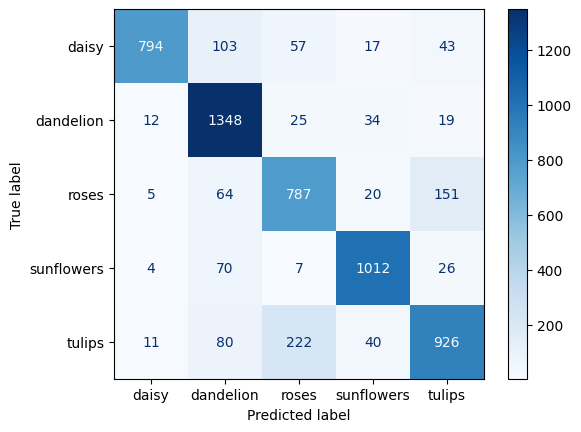

Confusion matrix image saved as outputs/v8/confusion_matrix.png
Evaluation saved as outputs/v8/model_evaluation.json


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 43264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     2,768,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,378,609 (31.96 MB)

 Trainable params: 2,792,869 (10.65 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,585,740 (21.31 MB)

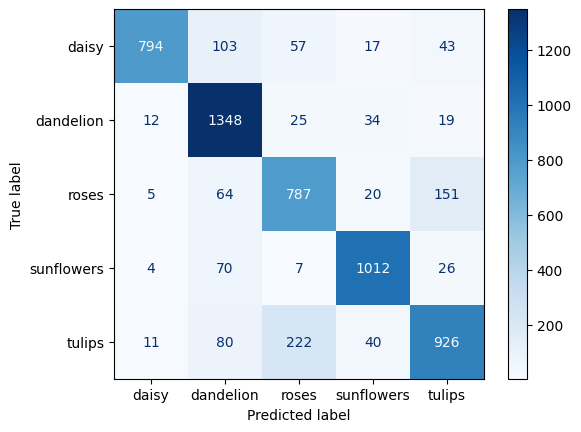

In [13]:
# Savepaths for the model evaluation and confusion matrix
pipeline.evaluate(savepath=f"{file_path}/model_evaluation.json", cm_image_path=f"{file_path}/confusion_matrix.png")
pipeline.model_summary()

### Plot the training history

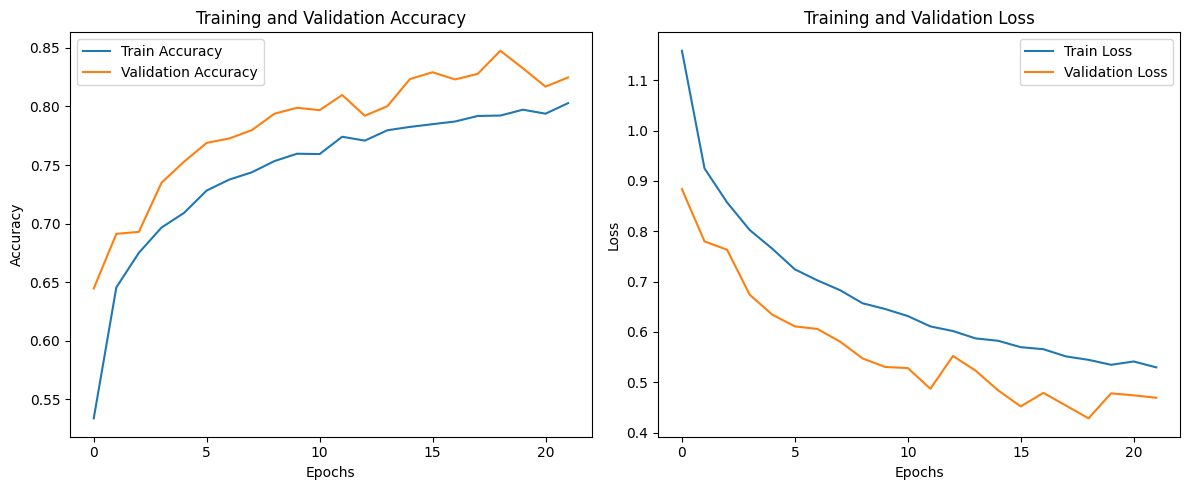

In [14]:
pipeline.plot_training_history(savepath=f"{file_path}/training_history.png")

### Evaluation of the performance

In [15]:
def load_and_display_evaluation_results(file_path):
    """
    Loads and displays the evaluation results from a JSON file, including the weighted F1 score, 
    classification report, and confusion matrix. The classification report is formatted into a 
    readable DataFrame, and the confusion matrix is displayed as a DataFrame with labels.

    Parameters:
    - file_path: str, path to the directory containing the 'model_evaluation.json' file.

    Outputs:
    - Prints the weighted F1 score.
    - Prints the formatted classification report as a DataFrame.
    - Prints the confusion matrix as a DataFrame.
    """
    json_file = f"{file_path}/model_evaluation.json"

    # Load evaluation data from the JSON file
    with open(json_file, 'r') as f:
        evaluation_data = json.load(f)
    
    # Print the weighted F1 score
    print(f"Weighted F1 Score: {evaluation_data['f1_score_weighted']:.4}\n")


    # Transforms the classification report into a more readable DataFrame format
    classification_report_df = pd.DataFrame(evaluation_data['classification_report']).transpose()
    classification_report_df = classification_report_df.round(4)

    # Add a blank row for readability and rearrange the rows
    classification_report_df = pd.concat([
        classification_report_df.iloc[:-3],  
        pd.DataFrame([[''] * len(classification_report_df.columns)], columns=classification_report_df.columns),  
        classification_report_df.iloc[-3:]  
    ]).reset_index()

    classification_report_df.index.name = None

    # Set display options for better formatting
    pd.set_option('display.colheader_justify', 'center')
    pd.set_option('display.width', 100)

    # Print the classification report
    print("Classification Report:\n", classification_report_df.to_string(index=False))

    # Create and print the confusion matrix as a DataFrame
    labels = list(evaluation_data['classification_report'].keys())[:-3] # Excludes the last 3 labels
    confussion_matrix_df = pd.DataFrame(
        evaluation_data['confusion_matrix'],
        index = labels,
        columns = labels
    )

    print("\nConfussion Matrix:\n", confussion_matrix_df)



### Show evaluation of the performance

In [16]:
load_and_display_evaluation_results(file_path)

Weighted F1 Score: 0.8277

Classification Report:
    index     precision  recall f1-score support
       daisy   0.9613    0.783   0.863   1014.0
   dandelion   0.8096   0.9374  0.8688   1438.0
       roses   0.7168   0.7663  0.7407   1027.0
  sunflowers   0.9012   0.9044  0.9028   1119.0
      tulips   0.7948    0.724  0.7578   1279.0
           0                                   
    accuracy   0.8281   0.8281  0.8281   0.8281
   macro avg   0.8367    0.823  0.8266   5877.0
weighted avg   0.8338   0.8281  0.8277   5877.0

Confussion Matrix:
             daisy  dandelion  roses  sunflowers  tulips
daisy        794      103       57        17        43 
dandelion     12     1348       25        34        19 
roses          5       64      787        20       151 
sunflowers     4       70        7      1012        26 
tulips        11       80      222        40       926 


### Prediction of a random image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


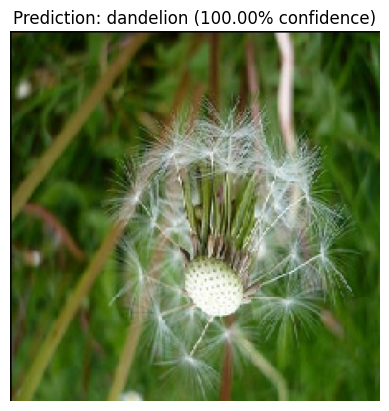

In [18]:
def predict_random_image(model, label_map, img_path, target_size=(224, 224)):
    
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  
    img_array /= 255.0  

    # Makes a prediction of a random image
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]
    predicted_label = label_map[predicted_class]
    confidence = predictions[0][predicted_class] * 100


    plt.imshow(img)
    plt.title(f"Prediction: {predicted_label} ({confidence:.2f}% confidence)")
    plt.axis('off')
    plt.show()


test_dir = "inputs/dataset/raw/flower_photos/test"  
random_class = random.choice(os.listdir(test_dir))  # Choose a random image
random_img_path = os.path.join(test_dir, random_class, random.choice(os.listdir(os.path.join(test_dir, random_class))))

# Prediction of an image
predict_random_image(pipeline.model, pipeline.label_map, random_img_path)

<hr>

## Results of all versions tested


| Version | Balanced / Unbalanced | Layers           | Kernels       | Total params   | Runtime | Accuracy | F1-Score | Comments                                                        |
| ------- | --------------------- | ---------------- | -------------  | -------------- | ------- | -------- | -------- | --------------------------------------------------------------- |
| 1       | Unbalanced            | 32 - 64 - 128    | 3x3, 3x3, 3x3 | 33,508,817     | 209 min | 0.8329   | 0.8336   | Good result, though very large model file. Going to half the layers and see if the result will be the same and lesser size of the .h5-file |
| 2       | Unbalanced            | 16 - 32 - 64     | 3x3, 3x3, 3x3 | 8,378,609      | 124 min | 0.8258   | 0.8244   | Good result, almost the same result when decreasing the layers to the half of the first version. The model now are around 33Mb instead of over 130Mb with the first model |
| 3       | Unbalanced            | 16 - 32 - 64     | 5x5, 5x5, 5x5 | 7,274,993      | 156 min | 0.8167   | 0.8183   | Good result, almost identical even when increasing the kernel size. Still the largest confusion is between tulips and roses |
| 4       | Unbalanced            | 16 - 32 - 64     | 5x5, 5x5, 5x5 | 223,729      | 55 min | 0.7087   | 0.6998   | Tried GlobalAveragePooling2D instead of Flatten on this layer and it didn´t go so well. Changing back to Flatten for the next version and increasing the layers. |
| 5       | Unbalanced            | 32 - 64 - 64     | 5x5, 5x5, 5x5 | 14,627,857      | 347 min | 0.7021   | 0.6819   | Adjust the augmentation with this model and the performance decreased instead. Will try next time with a balanced version 2. See if the performance of that can increase |
| 6       | Balanced (Undersampled)           | 16 - 32 - 64     | 3x3, 3x3, 3x3 | 8,379,505      | 68 min | 0.3536   | 0.2851   | Poor result when undersampled the categories. Settings where the same as the best performance at version 2. Ran with BatchNormalization() that made a poor result |
| 7       | Balanced (Oversampled)           | 16 - 32 - 64     | 3x3, 3x3, 3x3 | 8,378,609      | 129 min | 0.8193   | 0.8189   | Deleted BatchNormalization in every layer and got a result very similar to version 2. Seems like oversampling didn´t do that much to the performance. |